In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px  # For spatial maps and treemap

# Plot styling
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True
})

# ---------------------
# File Paths
# ---------------------

# Online datasets
AIRPORT_PATH = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/complaints-by-airport.csv"
CATEGORY_PATH = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/complaints-by-category.csv"
IATA_PATH = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/iata-icao.csv"

# Local dataset (big file)
# Replace this with the path you copy from Finder
SUBCAT_PATH = r"/Users/Alexandria/DSC 640/complaints-by-subcategory.csv"

# ---------------------
# Load Data
# ---------------------
air_by_airport = pd.read_csv(AIRPORT_PATH)
air_by_category = pd.read_csv(CATEGORY_PATH)
iata_icao = pd.read_csv(IATA_PATH)

# Load subcategory locally, with chunking if too big
try:
    air_by_subcat = pd.read_csv(SUBCAT_PATH)
except MemoryError:
    chunks = pd.read_csv(SUBCAT_PATH, chunksize=500_000)
    air_by_subcat = pd.concat(chunks, ignore_index=True)

# Quick preview
print(air_by_airport.shape, air_by_category.shape, air_by_subcat.shape, iata_icao.shape)
air_by_subcat.head()


(41721, 4) (241588, 7) (504512, 11) (8937, 7)


,pdf_report_date,airport,category,subcategory,year_month,count,clean_cat,clean_subcat,clean_cat_status,clean_subcat_status,is_category_prefix_removed
0,2019-02,ABE,Hazardous Materials Safety,General,2015-01,0,Hazardous Materials Safety,General,original,original,False
1,2019-02,ABE,Mishandling of Passenger Property,Damaged/Missing Items--Checked Baggage,2015-01,0,Mishandling of Passenger Property,*Damaged/Missing Items--Checked Baggage,original,original,False
2,2019-02,ABE,Hazardous Materials Safety,General,2015-02,0,Hazardous Materials Safety,General,original,original,False
3,2019-02,ABE,Mishandling of Passenger Property,Damaged/Missing Items--Checked Baggage,2015-02,0,Mishandling of Passenger Property,*Damaged/Missing Items--Checked Baggage,original,original,False
4,2019-02,ABE,Hazardous Materials Safety,General,2015-03,0,Hazardous Materials Safety,General,original,original,False


In [2]:
# TSA Complaints — Full Story (Python, Local + URLs)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Plotly for spatial and treemap (custom visual)
# If you don't have it: pip install plotly
import plotly.express as px
from IPython.display import display, Markdown

# Styling for matplotlib
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True
})


In [3]:
# GitHub raw data URLs
AIRPORT_PATH = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/complaints-by-airport.csv"
CATEGORY_PATH = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/complaints-by-category.csv"
IATA_PATH     = "https://raw.githubusercontent.com/taylorduncan/DSC640/main/iata-icao.csv"

# Local dataset (big file) — REPLACE THIS WITH YOUR PATH (use Finder → Option-right-click → Copy as Pathname)
SUBCAT_PATH = r"/Users/Alexandria/DSC 640/complaints-by-subcategory.csv"


In [4]:
def load_subcategory_local(path_or_base: str) -> pd.DataFrame:
    """
    Load the subcategory dataset from a local path.
    Accepts:
      - .parquet
      - .zip (CSV inside)
      - .csv
    Falls back to chunked CSV if a MemoryError occurs.
    If given a stem without suffix, tries .parquet, .zip, .csv in that order.
    """
    p = Path(path_or_base)
    if p.suffix.lower() == ".parquet":
        return pd.read_parquet(p)
    if p.suffix.lower() == ".zip":
        return pd.read_csv(p, compression="zip")
    if p.suffix.lower() == ".csv":
        try:
            return pd.read_csv(p)
        except MemoryError:
            chunks = pd.read_csv(p, chunksize=500_000)
            return pd.concat(chunks, ignore_index=True)

    # If they provided a stem without suffix, try common options
    stem = Path(path_or_base).with_suffix("")
    for ext in [".parquet", ".zip", ".csv"]:
        candidate = stem.with_suffix(ext)
        if candidate.exists():
            return load_subcategory_local(str(candidate))

    raise FileNotFoundError(
        f"Couldn't load subcategory file. Checked: {p} and "
        f"{stem.with_suffix('.parquet')}, {stem.with_suffix('.zip')}, {stem.with_suffix('.csv')}"
    )


In [5]:
# Load URL-based CSVs
air_by_airport  = pd.read_csv(AIRPORT_PATH)
air_by_category = pd.read_csv(CATEGORY_PATH)
iata_icao       = pd.read_csv(IATA_PATH)

# Load local, potentially large subcategory file
air_by_subcat = load_subcategory_local(SUBCAT_PATH)

print("Shapes:", air_by_airport.shape, air_by_category.shape, air_by_subcat.shape, iata_icao.shape)
air_by_airport.head()


Shapes: (41721, 4) (241588, 7) (504512, 11) (8937, 7)


,pdf_report_date,airport,year_month,count
0,2019-02,ABE,2015-01,0
1,2019-02,ABE,2015-02,0
2,2019-02,ABE,2015-03,0
3,2019-02,ABE,2015-04,0
4,2019-02,ABE,2015-05,2


In [6]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def find_count_col(df):
    for c in ["complaints","count","counts","total","n","value"]:
        if c in df.columns:
            return c
    # fallback to first numeric
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

# Clean columns
air_by_airport  = clean_cols(air_by_airport)
air_by_category = clean_cols(air_by_category)
air_by_subcat   = clean_cols(air_by_subcat)
iata_icao       = clean_cols(iata_icao)

# Keys & counts
airport_code_col_airport = find_col(air_by_airport,  ["airport_code","airport","code","iata"])
airport_code_col_cat     = find_col(air_by_category, ["airport_code","airport","code","iata"])
airport_code_col_sub     = find_col(air_by_subcat,   ["airport_code","airport","code","iata"])
iata_code_col            = find_col(iata_icao,       ["iata","code","airport_code"])

count_col_airport = find_count_col(air_by_airport)
count_col_cat     = find_count_col(air_by_category)
count_col_sub     = find_count_col(air_by_subcat)

lat_col = find_col(iata_icao, ["latitude","lat"])
lon_col = find_col(iata_icao, ["longitude","lon","long"])

print("Detected columns:")
print("- air_by_airport :", air_by_airport.columns.tolist())
print("- air_by_category:", air_by_category.columns.tolist())
print("- air_by_subcat  :", air_by_subcat.columns.tolist())
print("- iata_icao      :", iata_icao.columns.tolist())

print("\nKeys/Counts:")
print(" airport (airport) :", airport_code_col_airport)
print(" airport (category):", airport_code_col_cat)
print(" airport (subcat)  :", airport_code_col_sub)
print(" iata in lookup    :", iata_code_col)
print(" counts (a/c/s)    :", count_col_airport, count_col_cat, count_col_sub)
print(" lat/lon in lookup :", lat_col, lon_col)

# Merge IATA lookup into airport table for mapping
merged_airports = air_by_airport.merge(
    iata_icao, left_on=airport_code_col_airport, right_on=iata_code_col, how="left"
)
merged_airports_geo = merged_airports.dropna(subset=[lat_col, lon_col]) if (lat_col and lon_col) else merged_airports.copy()
merged_airports_geo.head()


Detected columns:
- air_by_airport : ['pdf_report_date', 'airport', 'year_month', 'count']
- air_by_category: ['pdf_report_date', 'airport', 'category', 'year_month', 'count', 'clean_cat', 'clean_cat_status']
- air_by_subcat  : ['pdf_report_date', 'airport', 'category', 'subcategory', 'year_month', 'count', 'clean_cat', 'clean_subcat', 'clean_cat_status', 'clean_subcat_status', 'is_category_prefix_removed']
- iata_icao      : ['country_code', 'region_name', 'iata', 'icao', 'airport', 'latitude', 'longitude']

Keys/Counts:
 airport (airport) : airport
 airport (category): airport
 airport (subcat)  : airport
 iata in lookup    : iata
 counts (a/c/s)    : count count count
 lat/lon in lookup : latitude longitude


,pdf_report_date,airport_x,year_month,count,country_code,region_name,iata,icao,airport_y,latitude,longitude
0,2019-02,ABE,2015-01,0,US,Pennsylvania,ABE,KABE,Lehigh Valley International Airport,40.6521,-75.4408
1,2019-02,ABE,2015-02,0,US,Pennsylvania,ABE,KABE,Lehigh Valley International Airport,40.6521,-75.4408
2,2019-02,ABE,2015-03,0,US,Pennsylvania,ABE,KABE,Lehigh Valley International Airport,40.6521,-75.4408
3,2019-02,ABE,2015-04,0,US,Pennsylvania,ABE,KABE,Lehigh Valley International Airport,40.6521,-75.4408
4,2019-02,ABE,2015-05,2,US,Pennsylvania,ABE,KABE,Lehigh Valley International Airport,40.6521,-75.4408


/var/folders/_7/5rzj_m210gj3m2dzm6h059zh0000gp/T/ipykernel_747/344818391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_airports_geo[lat_col] = pd.to_numeric(merged_airports_geo[lat_col], errors="coerce")
/var/folders/_7/5rzj_m210gj3m2dzm6h059zh0000gp/T/ipykernel_747/344818391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_airports_geo[lon_col] = pd.to_numeric(merged_airports_geo[lon_col], errors="coerce")
/var/folders/_7/5rzj_m210gj3m2dzm6h059zh0000gp/T/ipykernel_747/344818391.py:5:

Using hover_name: airport_x
Available columns: ['pdf_report_date', 'airport_x', 'year_month', 'count', 'country_code', 'region_name', 'iata', 'icao', 'airport_y', 'latitude', 'longitude']


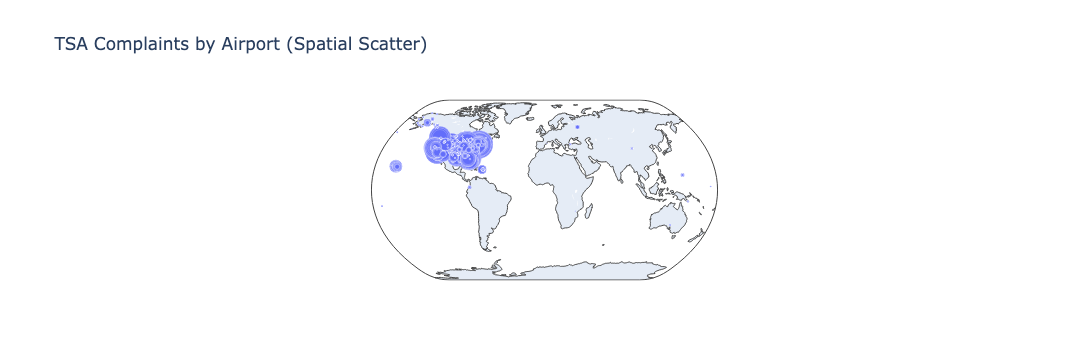

In [7]:
# ---- Visual 1: Spatial Map ----
# Ensure numeric fields for mapping/size
merged_airports_geo[lat_col] = pd.to_numeric(merged_airports_geo[lat_col], errors="coerce")
merged_airports_geo[lon_col] = pd.to_numeric(merged_airports_geo[lon_col], errors="coerce")
merged_airports_geo[count_col_airport] = pd.to_numeric(
    merged_airports_geo[count_col_airport], errors="coerce"
).clip(lower=0)

# Pick a safe hover label after merge (handles airport_x/airport_y/iata gracefully)
possible_hover = [
    airport_code_col_airport,  # e.g., "airport_code" or "airport"
    "airport_x",               # left table's airport name after merge
    "iata",                    # code from lookup table
    "icao",
    "airport_y"                # lookup table's airport name after merge
]
hover_name_col = next((c for c in possible_hover if c in merged_airports_geo.columns), None)
if hover_name_col is None:
    merged_airports_geo["airport_label"] = merged_airports_geo.index.astype(str)
    hover_name_col = "airport_label"

print("Using hover_name:", hover_name_col)
print("Available columns:", merged_airports_geo.columns.tolist())

# Filter to valid rows before plotting
plot_df = merged_airports_geo.dropna(subset=[lat_col, lon_col, count_col_airport]).copy()

if lat_col and lon_col and count_col_airport and not plot_df.empty:
    fig = px.scatter_geo(
        plot_df,
        lat=lat_col,
        lon=lon_col,
        size=count_col_airport,
        hover_name=hover_name_col,
        projection="natural earth",  # or use: fig.update_geos(scope="usa")
        title="TSA Complaints by Airport (Spatial Scatter)",
    )
    fig.update_traces(marker_line_width=0.3)
    # fig.update_geos(scope="usa")  # uncomment for US-only view
    fig.show()
else:
    print("Missing lat/lon/size columns or no valid rows; skipping spatial scatter.")


/var/folders/_7/5rzj_m210gj3m2dzm6h059zh0000gp/T/ipykernel_747/3147636529.py:38: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



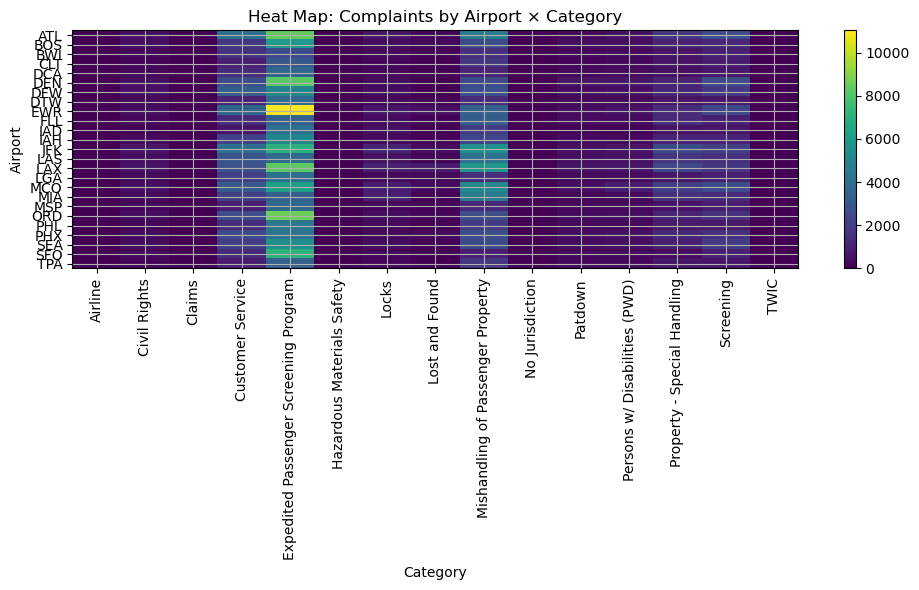

In [8]:
# Identify category column
category_col = None
for c in ["category","complaint_category","cat"]:
    if c in air_by_category.columns:
        category_col = c
        break

if (airport_code_col_cat is not None) and (category_col is not None) and (count_col_cat is not None):
    N_airports = 25
    N_cats = 15

    top_airports = (
        air_by_category.groupby(airport_code_col_cat)[count_col_cat].sum()
        .sort_values(ascending=False).head(N_airports).index
    )
    top_cats = (
        air_by_category.groupby(category_col)[count_col_cat].sum()
        .sort_values(ascending=False).head(N_cats).index
    )

    heat_df = air_by_category[
        air_by_category[airport_code_col_cat].isin(top_airports)
        & air_by_category[category_col].isin(top_cats)
    ]

    pivot = heat_df.pivot_table(index=airport_code_col_cat, columns=category_col,
                                values=count_col_cat, aggfunc="sum", fill_value=0)

    fig, ax = plt.subplots()
    im = ax.imshow(pivot.values, aspect="auto", interpolation="nearest")
    ax.set_title("Heat Map: Complaints by Airport × Category")
    ax.set_xlabel("Category")
    ax.set_ylabel("Airport")
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns, rotation=90)
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print("Could not detect needed columns for the heat map.")


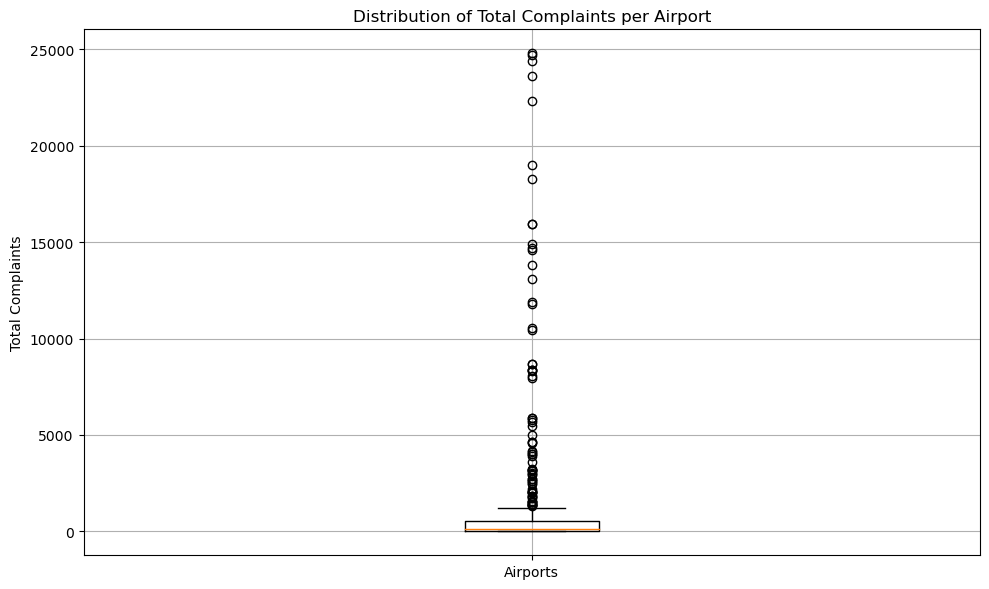

In [9]:
if count_col_airport and airport_code_col_airport:
    airport_totals = (
        air_by_airport.groupby(airport_code_col_airport)[count_col_airport]
        .sum()
        .reset_index(name="total_complaints")
    )

    fig, ax = plt.subplots()
    ax.boxplot(airport_totals["total_complaints"].dropna(), vert=True, labels=["Airports"])
    ax.set_title("Distribution of Total Complaints per Airport")
    ax.set_ylabel("Total Complaints")
    plt.tight_layout()
    plt.show()
else:
    print("Missing count column on airport table; skipping box plot.")


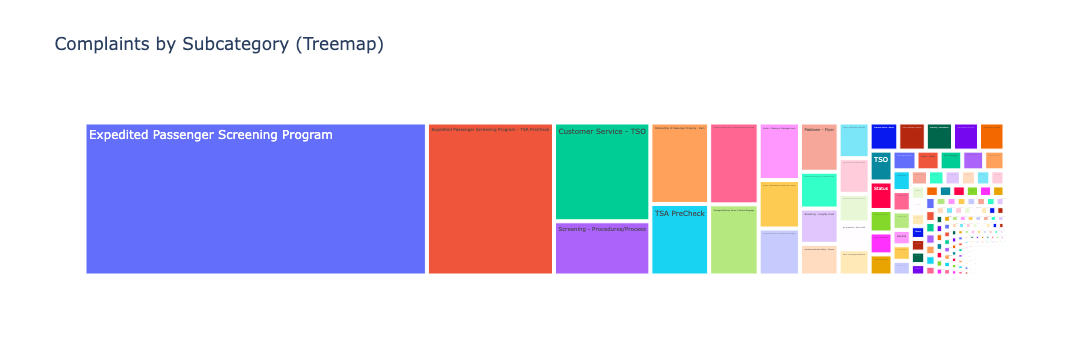

In [10]:
# Detect subcategory column
subcat_col = None
for c in ["subcategory","sub_category","complaint_subcategory","subcat"]:
    if c in air_by_subcat.columns:
        subcat_col = c
        break

if subcat_col and count_col_sub:
    treemap_df = (
        air_by_subcat.groupby(subcat_col)[count_col_sub].sum().reset_index()
        .sort_values(count_col_sub, ascending=False)
    )
    fig = px.treemap(
        treemap_df, path=[subcat_col], values=count_col_sub,
        title="Complaints by Subcategory (Treemap)"
    )
    fig.show()
else:
    print("Missing subcategory or count column; skipping treemap.")


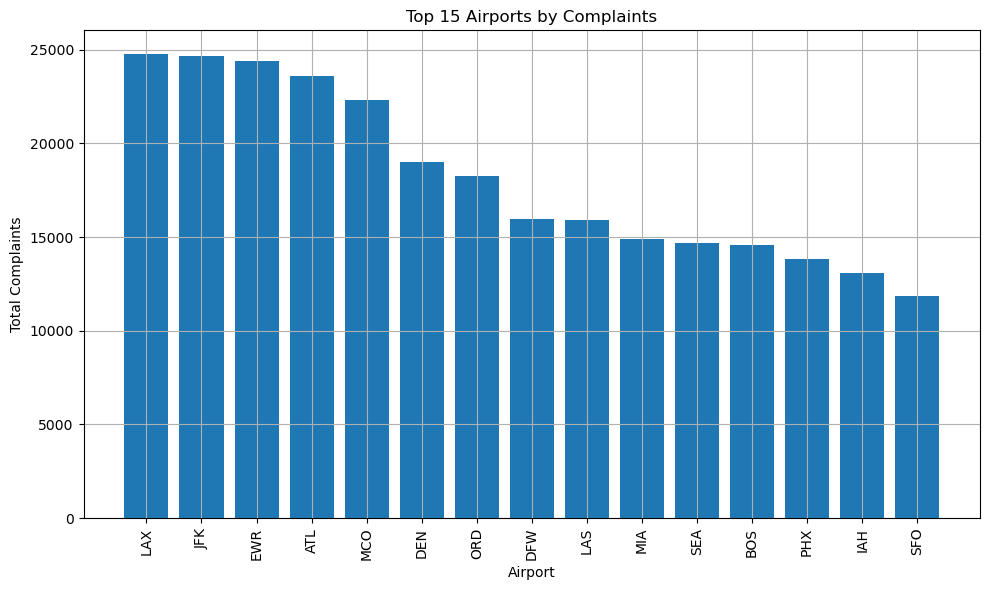

In [11]:
if count_col_airport and airport_code_col_airport:
    top_n = 15
    airport_totals = (
        air_by_airport.groupby(airport_code_col_airport)[count_col_airport]
        .sum()
        .reset_index(name="total_complaints")
    )
    top_airports_bar = airport_totals.sort_values("total_complaints", ascending=False).head(top_n)

    fig, ax = plt.subplots()
    ax.bar(top_airports_bar[airport_code_col_airport], top_airports_bar["total_complaints"])
    ax.set_title(f"Top {top_n} Airports by Complaints")
    ax.set_xlabel("Airport")
    ax.set_ylabel("Total Complaints")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Missing count/airport columns; skipping top airports bar chart.")


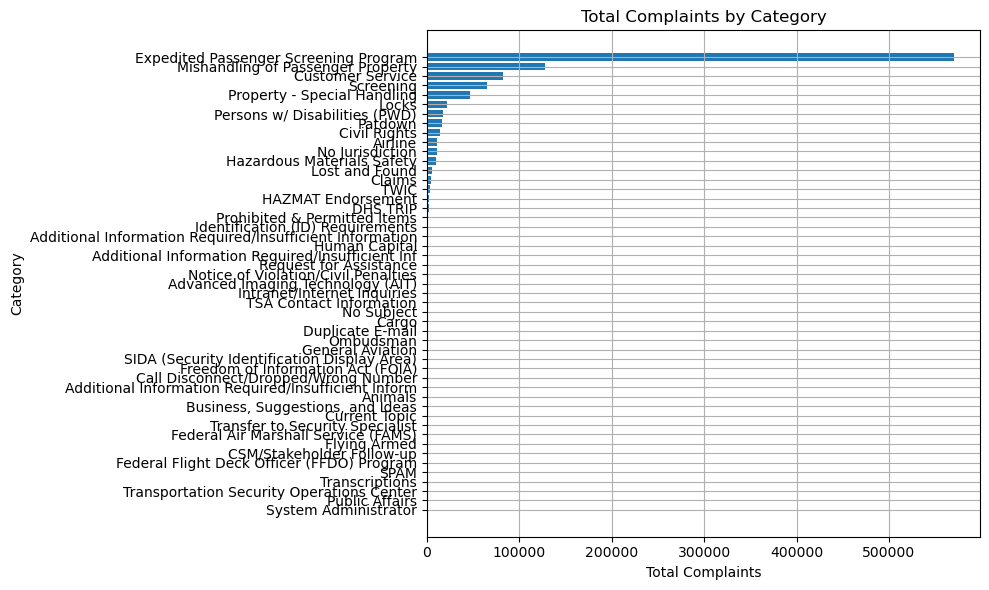

In [12]:
if category_col and count_col_cat:
    cat_totals = (
        air_by_category.groupby(category_col)[count_col_cat].sum().sort_values(ascending=True)
    )
    fig, ax = plt.subplots()
    ax.barh(cat_totals.index, cat_totals.values)
    ax.set_title("Total Complaints by Category")
    ax.set_xlabel("Total Complaints")
    ax.set_ylabel("Category")
    plt.tight_layout()
    plt.show()
else:
    print("Missing category or count column; skipping category totals chart.")


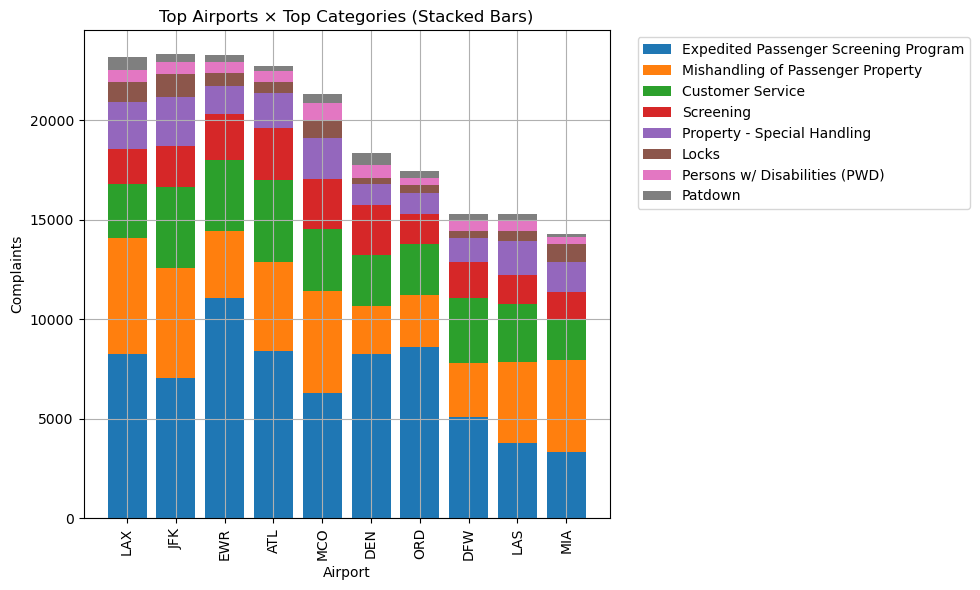

In [13]:
if (airport_code_col_cat is not None) and (category_col is not None) and (count_col_cat is not None):
    top_airports2 = (
        air_by_category.groupby(airport_code_col_cat)[count_col_cat].sum()
        .sort_values(ascending=False).head(10).index
    )
    top_cats2 = (
        air_by_category.groupby(category_col)[count_col_cat].sum()
        .sort_values(ascending=False).head(8).index
    )

    tmp = air_by_category[
        air_by_category[airport_code_col_cat].isin(top_airports2)
        & air_by_category[category_col].isin(top_cats2)
    ]

    mat = tmp.pivot_table(index=airport_code_col_cat, columns=category_col,
                          values=count_col_cat, aggfunc="sum", fill_value=0)
    mat = mat.loc[top_airports2, top_cats2]  # enforce order

    fig, ax = plt.subplots()
    bottom = np.zeros(len(mat))
    for col in mat.columns:
        ax.bar(mat.index, mat[col].values, bottom=bottom, label=col)
        bottom += mat[col].values
    ax.set_title("Top Airports × Top Categories (Stacked Bars)")
    ax.set_xlabel("Airport")
    ax.set_ylabel("Complaints")
    plt.xticks(rotation=90)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Needed columns for stacked bars not found; skipping.")


In [14]:
narrative = """
## Narrative, Design, and Ethics (with Call to Action)

**Audience.** The primary audience is TSA regional operations managers and airport policy decision-makers with moderate data literacy. They regularly review operational KPIs but may be less familiar with how complaint types cluster across airports and regions.

**Purpose and Call to Action.** The objective is to reveal where and why TSA complaints concentrate—by airport, category, and subcategory—to guide targeted interventions. **Call to action:** within 30 days, approve and launch focused audits and staff retraining at the **five highest-complaint airports**, prioritizing the **top three complaint categories** at each location. Actions include checkpoint workflow reviews, traveler signage/communication enhancements, and process standardization for high-friction screening steps.

**Medium.** Findings are presented in this interactive Jupyter Notebook for transparency (code + data) and drill-downs. For executives, export the key visuals to a concise slide deck with the selected hotspots, proposed actions, and expected metrics.

**Design (Gestalt principles).** Visual hierarchy moves overview → detail-on-demand: the **spatial map** surfaces geographic hotspots, the **heat map** shows airport×category friction points, and the **box plot** summarizes dispersion in airport performance. **Color** intensity indicates higher complaint volume. **Alignment and spacing** group related visuals and annotations to support proximity and continuity. **Sizing** emphasizes the map and heat map as decision drivers.

**Ethical considerations.** Data is public and aggregated; no PII is present. Cleaning steps include standardizing column names, merging on IATA codes, excluding rows without geocoordinates for the spatial visual, and grouping unknown categories as “Unspecified.” All filters and assumptions are declared to avoid hidden exclusions. Risks—like underreporting or seasonality—are noted to reduce misinterpretation. The narrative avoids blaming specific airports or staff, framing insights as opportunities for system improvement.

**Outcome.** Executing the 30-day remediation plan should reduce traveler pain points at priority airports, improve public sentiment, and strengthen compliance with security standards. Follow-up monitoring should track complaint volume and mix post-intervention to evaluate impact and guide iteration.
"""
display(Markdown(narrative))



## Narrative, Design, and Ethics (with Call to Action)

**Audience.** The primary audience is TSA regional operations managers and airport policy decision-makers with moderate data literacy. They regularly review operational KPIs but may be less familiar with how complaint types cluster across airports and regions.

**Purpose and Call to Action.** The objective is to reveal where and why TSA complaints concentrate—by airport, category, and subcategory—to guide targeted interventions. **Call to action:** within 30 days, approve and launch focused audits and staff retraining at the **five highest-complaint airports**, prioritizing the **top three complaint categories** at each location. Actions include checkpoint workflow reviews, traveler signage/communication enhancements, and process standardization for high-friction screening steps.

**Medium.** Findings are presented in this interactive Jupyter Notebook for transparency (code + data) and drill-downs. For executives, export the key visuals to a concise slide deck with the selected hotspots, proposed actions, and expected metrics.

**Design (Gestalt principles).** Visual hierarchy moves overview → detail-on-demand: the **spatial map** surfaces geographic hotspots, the **heat map** shows airport×category friction points, and the **box plot** summarizes dispersion in airport performance. **Color** intensity indicates higher complaint volume. **Alignment and spacing** group related visuals and annotations to support proximity and continuity. **Sizing** emphasizes the map and heat map as decision drivers.

**Ethical considerations.** Data is public and aggregated; no PII is present. Cleaning steps include standardizing column names, merging on IATA codes, excluding rows without geocoordinates for the spatial visual, and grouping unknown categories as “Unspecified.” All filters and assumptions are declared to avoid hidden exclusions. Risks—like underreporting or seasonality—are noted to reduce misinterpretation. The narrative avoids blaming specific airports or staff, framing insights as opportunities for system improvement.

**Outcome.** Executing the 30-day remediation plan should reduce traveler pain points at priority airports, improve public sentiment, and strengthen compliance with security standards. Follow-up monitoring should track complaint volume and mix post-intervention to evaluate impact and guide iteration.
